In [87]:
"""Lennard-Jones for specific atom"""

import numpy as np
import copy as cp
import matplotlib.pyplot as plt
from make_animation import make_3d_animation

def initialize_arrays(t_range, N, dim):
    '''Function containing all the initialization of the necesarry arrays. Names should speak for themself.'''
    
    pos = np.zeros((len(t_range),N,dim),dtype=float)
    differ = np.zeros((len(t_range),N,N),dtype=float)
    E_pot = np.zeros((len(t_range),1),dtype=float)
    C_v = np.zeros((len(t_range),1),dtype=float)
    E_kin = np.zeros((len(t_range),1),dtype=float)
    T_tot = np.zeros((len(t_range),1),dtype=float)
    N_inter = np.zeros((len(t_range),1),dtype=float)
    Sum_rF = np.zeros((len(t_range),1),dtype=float)    
    return pos, differ, E_pot, C_v, E_kin, T_tot, N_inter, Sum_rF 

class atom_props():
    """Redunant class, can be deleted 
    Sets atom properties
    
    Parameters: 
    -----------
    sigma: float
        sigma of the atom, self.sig
    epsilon: float
        epsilon of atom, self.eps
    mass: floast
        mass of the atom, self.m
    
    """
    def __init__(self, sigma, epsilon, mass):
        self.sig = sigma
        self.eps = epsilon
        self.m = mass

def pot_LJ(atom,r):
    """Regular Lenard Jones potential, based on atom properties and distance"""
    sig = atom.sig
    eps = atom.eps
    return 4*eps*((sig/r)**12 - (sig/r)**6)   

def pot_LJ_dl(r):
    """Dimensionless Lenard Jones potential, based on distances"""
    r = r**-6 # Possibly improves speed
    u = 4*(r**2 - r)        
    return u

def grad_pot_LJ_dl(r):
    """Diff of the Lennard Jones potential wrt r, dimensionless"""
    return (-48*r**-6 + 24)*r**-7 

def particle_generator(lattice, L, N, dim):
    """Generates initial particle position and velocity.
    
    Parameters:
    -----------
    lattice: string
        random: arbitrary ammount of particles and dimensions randomly distributed 
        fcc: 3d 4 particles on fcc lattice 
    L: float
        size of the simulation box
    N: int
        Number of particles, should be n^3 where n is the amount of boxes in one direction
    dim: int
        Number of dimensions, should be 3 for fcc     
    """
    if lattice == "random":
        x_init = np.random.random((dim,N))*L
        
    if lattice == "fcc":
        
        if (unit_cells == unit_power**3) and dim == 3:
            # Primitive unit cell coordinates for fcc
            initial_unit_cell = np.array([[0,0,unit_size/2,unit_size/2],
                                          [0,unit_size/2,0,unit_size/2],
                                          [0,unit_size/2,unit_size/2,0]])
            
            # Create list width 1d coordinate of every starting cell
            a =[]
            for p in range(unit_power):
                a.append([unit_size*p])
            
            # Create a 1d grid of all unit cell corners
            arr = np.array([arr.flatten() for arr in np.meshgrid(a,a,a)])
            
            # Create array with all the translated unit cell coordinates
            fcc_coordinates = np.array([[],[],[]])
            for j in range(unit_power**3):
                tempor = arr[:, j].reshape(dim,1) + initial_unit_cell 
                fcc_coordinates = np.concatenate([fcc_coordinates, tempor], axis = 1)

            x_init = fcc_coordinates
            
        else:
            print('The dimension is not equal to 3 or the number of particles doesnt equal four.')
            import sys
            sys.exit()
            
    # v_init = np.zeros((dim,N),dtype=float)
    # Initial velocity chosen gaussian
    v_init = np.random.normal(0, np.sqrt(T), (dim,N))
    v_init = v_init - v_init.sum(axis = 1).reshape(3,1)/N #remove net velocity from the system
    return x_init, v_init


def particle_dist(L, N, x, dim):
    """"Calculate distances between NN particle pairs
    
    Parameters:
    -----------
    L: float
        size of the simulation box
    N: int
        Number of particles
    x: array of size (dim, N)
        Particle places   
    dim: int
        Number of dimensions  
    """
    # Calculate distances to NN
    r = np.zeros((N,N),dtype=float)
    delta_tot = np.zeros((dim,N,N),dtype=float)
    NN_max_dist = L/2       
    
    for i in range(dim):
        # Difference between coordinates per dimension
        delta = x[i,:]-np.transpose([x[i,:]])
        
        # New difference including 'virtu=al' coordinates
        delta[delta >= NN_max_dist] = -(L-delta[delta >= NN_max_dist])
        delta[delta < -NN_max_dist] = (L + delta[delta < -NN_max_dist])
        delta_tot[i] = delta
        r += delta**2   
    r = np.sqrt(r) 
    r[r == 0] = np.inf
    return delta_tot, r

def pot_and_force(delta_tot, r, dim, N):
    """Calculate forces between particles based on potential
    
    Parameters:
    -----------
    delta_tot: array of size (dim, N, N)
        Differenes between particles
    r: array of size (N, N)
        inter particle distances
    dim: int
        Number of dimensions  
    N: int
        Number of particles
    """
    # Potentials and Forces
    F = np.zeros((dim,N,N),dtype=float)
    U = sum(pot_LJ_dl(r).sum(axis=1))
    Force_grad = -grad_pot_LJ_dl(r)
    for i in range(dim):
        F[i] = Force_grad*delta_tot[i]/r
    
    F_sum = F.sum(axis=1)
    return F_sum, U

def xv_iteration(algorithm, x, v, F_tot_old, L, N, dim):
    """Euler or verlet arlgorithm for position and velocity
    
    Parameters:
    -----------
    algorithm: string
        verlet or euler, determinse the iterative process used
    x: array of size (dim,N)
        positions of all the particles
    v: array of size (dim,N)
        speed of all the particles
    F_tot_old: array of size (dim, N)
        total force on the particles, per particle at time step t, t + dt is calculated in this function
    L: float
        size of the simulation box
    N: int
        Number of particles
    dim: int
        Number of dimensions 
    """
    
    if algorithm == "euler":
        delta_tot, r = particle_dist(L, N, x, dim)
        F_tot, U = pot_and_force(delta_tot, r, dim, N)
        x = (x + v * delta_t)%L
        v = v + F_tot * delta_t
        
    if algorithm == "verlet":
        x = (x + v * delta_t + 0.5*delta_t**2 * F_tot_old)%L
        delta_tot, r = particle_dist(L, N, x, dim)
        F_tot, U = pot_and_force(delta_tot, r, dim, N)
        v = v + 0.5*delta_t * (F_tot + F_tot_old)
            
    return x, v, F_tot, U.sum(), r

def temp_check(E_kin, E_pot, v, T_tot, i, conf_level, check_time, sum_past, last_renorm_time):
    '''Determines if the temperature of the system agress 
    with the setup temperature, if not a renormalization 
    of the velocity is applied to correct for the kinetic energy
    
    Parameters:
    -----------
    E_kin: array of size (loop iteration i) 
        kinetic energy of the particles
    E_pot: array of size (loop iteration i)
        potential energy of the particles
    v: array of size (dim, N)
        particle velocity's
    T_tot: array of size (loop iteration)
        all past temeratures of the system
    i: int
        gives the loop iteration
    
    '''
    past_period = int(i-0.7*i)
    T_ave = (T_tot[i-past_period:i].sum())/past_period
    T_squ = (((T_tot[i-past_period:i])**2).sum())/past_period
    T_std = np.sqrt(T_squ - (T_ave)**2)  
    if (T < T_ave - conf_level*T_std or T > T_ave + conf_level*T_std):
        last_renorm_time = cp.deepcopy(i)
        lam = np.sqrt(((N-1)*3*T)/(2*E_kin[i]))
        v = lam * v
        renorm_check = True
    renorm_check = False
    return v, last_renorm_time, renorm_check

def pot_calc(U, v):
    '''Calculates the total energy of the system, potential and kinetic.
    
    Parameters:
    -----------
    U: array of size (N, N)
        potential interaction energy of all particles
    v: array of size (dim, N)
        velocit's of the particles
    '''
    E_pot = 0.5*U.sum()
    E_kin = 0.5*(v**2).sum(axis=1).sum(axis=0)
    return E_kin, E_pot

# Create random bootstrap sequence 
def btstrp_rnd_gen(trials, i, last_renorm_time):
    N = i-last_renorm_time
    a = np.round(np.random.random(trials*N).reshape(trials,N)*N+last_renorm_time)
    return a.astype(int)    

def specific_heat(trials, btstrp_seq, last_data_iteration, last_renorm_time, E_kin, N):
    '''Calculate the specific heat per particle from the fluctuation of the total kinetic energy, 
    where mean and sigma are determined using the bootstrapping method
    
    Returned parameters:
    ---------------------
    C_v_ave: float
        Average dimensionless specific heat per particle
    C_v_sig: float
        Standard deviation of the dimensionless specific heat per particle  
    '''
    C_v = np.zeros((trials,1), dtype=float)
    for j in range(trials):
        E_kin_ave = E_kin[btstrp_seq[j]].sum()/(last_data_iteration-last_renorm_time)
        fluc = (((E_kin[btstrp_seq[j]]-E_kin_ave)**2).sum()/(last_data_iteration-last_renorm_time))/E_kin_ave**2
        C_v[j] = 1/((2/(3*N))-fluc)/N
    C_v_ave = np.mean(C_v)
    C_v_sig = np.std(C_v)
    return C_v_ave, C_v_sig

def pressure(trials, btstrp_seq, last_data_iteration, last_renorm_time, Sum_rF, N, T):
    '''According to eq. 7.36 in Jos' book (beta*P/n)
    
    Returned parameter:
    -------------------
    P_ave: float
        Average dimensionless pressure (beta*P/n)
    P_sig: float
        Standard deviation of the dimensionless pressure (beta*P/n)  
    '''
    P = np.zeros((trials,1),dtype=float)
    for j in range(trials):
        Sum_rF_ave = Sum_rF[btstrp_seq[j]].sum()/(last_data_iteration-last_renorm_time)
        P[j] = 1+1/(3*N*T)*Sum_rF_ave
    P_ave = np.mean(P)
    P_sig = np.std(P)
    return P_ave, P_sig
    

In [88]:
# Configuration of the simulation

# Parameters
T = 0.5 # Kelvin /119.8
density = 1.2 

# Defining the geometry 
unit_power = 3                     # amount of cells alone 1 axis (drawn from 'xyz')
unit_cells = unit_power**3         # nubmer of cells in total
N_unit = 4                         # 4 partciles per unit cell
unit_size = (N_unit/density)**(1/3)
L = unit_size*(unit_power)         # Box size
N = N_unit*unit_cells              # number of particles 
dim = 3                            # Dimensions of the problem, fcc should use 3D

lattice = "fcc"                    # fcc or random
algorithm = "verlet"               # euler or velvet

# Renormalization parameters
conf_level = 1                    # amount of standard deviations from the average temperature
inter_numb = 2                    # Number of interactions per particle

# Bootstrap parameters
trials = 100 

In [89]:
# Main program
import time
start_time = time.time()

delta_t = 4e-3
t_max = 2000*delta_t

t_range = np.arange(0, t_max, delta_t) # time steps 
x_init, v_init = particle_generator(lattice,L, N, dim)
x = cp.deepcopy(x_init) # initial particle positions
v = cp.deepcopy(v_init) # initial particle velocitys
l_mfp = 1/N*(L**dim)/(np.pi*N*(1**(dim-1))) # mean free path per particle

delta_tot, r = particle_dist(L, N, x, dim) 
F_tot, U = pot_and_force(delta_tot, r, dim, N)

# Initializing all necesary arrays and floats
pos, differ, E_pot, C_v, E_kin, T_tot, N_inter, Sum_rF  = initialize_arrays(t_range, N, dim)
last_renorm_time = 0
sum_past = 0
N_inter_tot = 0
renorm_count = 0

for i, t in enumerate(t_range):
    E_kin[i], E_pot[i] = pot_calc(U, v)
    T_tot[i] = ((2*E_kin[i])/(3*(N-1)))
    t_mfp = l_mfp/(np.sqrt(2*E_kin[i]/N))
    N_inter_tot += delta_t/t_mfp # Number of interactions based on delta_t and mean free path.
    
    '''The following if statement check if enough interactions have 
    happened to be in equilibrium, also if it arrived here 10 times 
    but did not need to renormalize then it is assumed that final 
    equilibrium is achieved.'''
    
    if N_inter_tot > inter_numb*N and renorm_count < 10:
        v, last_renorm_time, renorm_check = temp_check(E_kin, E_pot, v, T_tot, i, conf_level, t, sum_past, last_renorm_time)
        
        if renorm_check == False:
            renorm_count += 1 # achieved equilibrium but no renormalization was needed.
            
        N_inter_tot = 0 # happened interactions set to 0 again
        sum_past = cp.deepcopy(i)
    
    x, v, F_tot, U, r = xv_iteration(algorithm, x, v, F_tot, L, N, dim)
    
    pos[i, :, :] = x.transpose()                # used for animation
    Sum_rF[i] = np.sum(np.sum(x*F_tot, axis=0)) # used for pressure 
    differ[i,:,:] = r                           # used for pair correlation
    
    if renorm_count >= 10 and i - last_renorm_time > 1000:
        '''Breaks if enough equilibrium data is aquired.'''
        break
    
last_data_iteration = cp.deepcopy(i)    
    
end_time = time.time()
print('N=',N,',','# Time steps = ',last_data_iteration)
print('Simulation time:', np.round(end_time - start_time,2), 's')

# Bootstrap sequence
btstrp_seq = btstrp_rnd_gen(trials, last_data_iteration, last_renorm_time)

# C_v & P 
P_ave, P_sig = pressure(trials, btstrp_seq, last_data_iteration, last_renorm_time, Sum_rF, N, T)
C_v_ave, C_v_sig = specific_heat(trials, btstrp_seq, last_data_iteration, last_renorm_time, E_kin, N)

print('P_ave =', np.round(P_ave,3),',','P_sig =', np.round(P_sig,3))
print('C_v_ave =', np.round(C_v_ave,3),',','C_v_sig =', np.round(C_v_sig,3))


N= 108 , # Time steps =  1523
Simulation time: 4.85 s
P_ave = 8.99 , P_sig = 0.055
C_v_ave = 4.551 , C_v_sig = 0.34


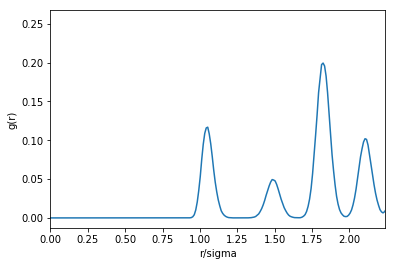

In [90]:
# auto correlation
pair_cor_trials = 1
btstrp_seq = btstrp_rnd_gen(pair_cor_trials, last_data_iteration, last_renorm_time)

bin_number = int(100*L)
hist_tot = np.zeros(bin_number-1,dtype=int)
for j in range(pair_cor_trials):
    diff_subset = differ[btstrp_seq[j]]
    hist, bin_edges = np.histogram(diff_subset[diff_subset!=np.inf], bins = np.linspace(0,L,bin_number))
    hist_tot += hist
    
hist_tot = hist_tot/trials/(N*(N-1))
plt.plot(bin_edges[:-1],hist_tot)
plt.xlim([0,L/2])
plt.ylabel('g(r)')
plt.xlabel('r/sigma')
plt.show()


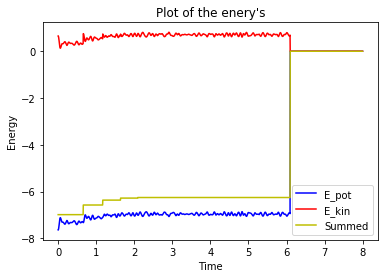

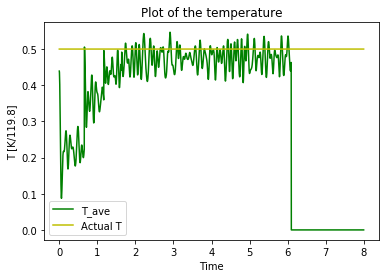

In [91]:
# Plotting of energy and temperature

plt.plot(t_range,E_pot/N,'b')
plt.plot(t_range,E_kin/N,'r')
plt.plot(t_range,(E_kin+E_pot)/N,'y')
plt.legend(['E_pot','E_kin','Summed'])
plt.title("Plot of the enery's")
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

plt.plot(t_range,T_tot,'g')
plt.plot(t_range,np.ones((len(t_range),1),dtype=float)*T,'y')
plt.legend(['T_ave','Actual T'])
plt.title("Plot of the temperature")
plt.xlabel('Time')
plt.ylabel('T [K/119.8]')
plt.show()


In [ ]:
# Make an animation

from IPython.display import HTML

anim = make_3d_animation(L, pos, delay=10, initial_view=(30, 20), rotate_on_play=0)
HTML(anim.to_html5_video())

In [81]:
    # force[i,:,:] = F_tot.transpose() Obsolete
    # vel[i,:,:] = v.transpose() Obsolete
    # 


10